In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from datetime import datetime
import sys
import gc
sys.path.append('../../')

from sklearn.model_selection import KFold
from tqdm import tqdm

from dependencies import *
from settings import *
from reproducibility import *
from models.TGS_salt.Unet34_scSE_hyper import Unet_scSE_hyper as Net

Using paths on kail-main

Importing numerical libraries...
Importing standard libraries...
Importing miscellaneous functions...
Importing constants...
Importing Neural Network dependencies...
	PyTorch
	Keras
	TensorFlow
	Metrics, Losses and LR Schedulers
	Kaggle Metrics
	Image augmentations
	Datasets
Importing external libraries...
	Lovasz Losses (elu+1)

Fixing random seed for reproducibility...
	Setting random seed to 35202.

Setting CUDA environment...
	torch.__version__              = 1.1.0
	torch.version.cuda             = 9.0.176
	torch.backends.cudnn.version() = 7501
	os['CUDA_VISIBLE_DEVICES']     = 0,1
	torch.cuda.device_count()      = 2



In [2]:
SIZE = 256
FACTOR = 256
ne = "ne"
initial_checkpoint = None
MODEL = "ResNet34"
#OHEM = "OHEM"

batch_size = 8
n_acc = 256 / batch_size
nfolds = 4

noise_th = 75.0*(SIZE/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

data_root = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:1')

In [3]:
def time_to_str(time, str):
    #if str == 'min':
    #	    return str(round(float(time)/60,5))+" min(s)"
    return round(time,4)

In [4]:
#TODO: Instead of directly printing to stdout, copy it into a txt file
class Logger():
    def __init__(self,name=MODEL+ne):
        super().__init__()
        self.model=name
        #if OHEM != "OHEM":
        #    self.model=MODEL+ne[ne.find("_")+1:]
        self.file = open(self.model+"_log.txt","w+")
        self.file.close()
        
        self.debug_file = open(self.model + '_debug.txt', 'w+')
        self.debug_file.close()
    def write(self, str):
        print(str)
        self.file = open(self.model+"_log.txt","a+")
        self.file.write(str)
        self.file.close()
    def write2(self, str):
        print(str, end='',flush=True)
        self.file = open(self.model+"_log.txt","a+")
        self.file.write(str)
        self.file.close()
    def debug(self, str):
        self.debug_file = open(self.model + '_debug.txt', 'a+')
        self.debug_file.write(str)
        self.debug_file.close()
    def stop():
        self.file.close()
        self.debug_file.close()
        
log = Logger()

In [5]:
def valid_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

def train_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())

    if np.random.rand() < 0.5:
         image, mask = do_horizontal_flip2(image, mask)
         pass

    if np.random.rand() < 0.2:
        c = np.random.choice(4)
        if c==0:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.1) #0.125

        if c==1:
            image, mask = do_horizontal_shear2( image, mask, dx=np.random.uniform(-0.02,0.02) )
            pass

        if c==2:
            image, mask = do_shift_scale_rotate2( image, mask, dx=0, dy=0, scale=1, angle=np.random.uniform(0,15))  #10

        if c==3:
            image, mask = do_elastic_transform2(image, mask, grid=10, distort=np.random.uniform(0,0.05))#0.10
            pass
    if np.random.rand() < 0.1:
        c = np.random.choice(3)
        if c==0:
            image = do_brightness_shift(image,np.random.uniform(-0.1,+0.1))
        if c==1:
            image = do_brightness_multiply(image,np.random.uniform(1-0.08,1+0.08))
        if c==2:
            image = do_gamma(image,np.random.uniform(1-0.08,1+0.08))
        # if c==1:
        #     image = do_invert_intensity(image)

    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

In [6]:
def null_augment(image, mask, index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    return image, mask, index, cache

def null_collate(batch):

    batch_size = len(batch)
    cache = []
    input = []
    truth = []
    index = []
    for b in range(batch_size):
        input.append(batch[b][0])
        truth.append(batch[b][1])
        index.append(batch[b][2])
        cache.append(batch[b][3])
    input = torch.from_numpy(np.array(input)).float().unsqueeze(1)

    if truth[0]!=[]:
        truth = torch.from_numpy(np.array(truth)).float().unsqueeze(1)

    return input, truth, index, cache

class SIIMDataset(Dataset):
    def __init__(self, data_root, fold, width=1024, height=1024, phase='train', augment=null_augment, random_state=2019, nfolds=4):
        self.data_root = data_root
        self.fold = fold
        self.height = width
        self.width = height
        self.phase = phase
        self.augment = augment
        
        kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
        train_list = os.listdir(os.path.join(data_root, 'train_png'))
        
        if phase == 'train':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][0]
            self.filenames = [train_list[i] for i in index_list]
        elif phase == 'val':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][1]
            self.filenames = [train_list[i] for i in index_list]
        else: # test
            self.filenames = os.listdir(os.path.join(data_root, 'test_png'))

    def __getitem__(self, index):
        img_path = os.path.join(self.data_root, 'train_png/{}'.format(self.filenames[index]))
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
        img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        if self.phase == 'test':
            mask = []
        else: # train and val
            mask_path = os.path.join(self.data_root, 'mask_png/{}'.format(self.filenames[index]))
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
            mask = cv2.resize(mask, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        return self.augment(img, mask, index)
    
    def __len__(self):
        return len(self.filenames)


In [7]:
def validation( net, valid_loader ):

    valid_num  = 0
    valid_loss = np.zeros(3, np.float32)
    
    logits = []
    truths = []
    for input, truth, index, cache in valid_loader:
        input = input.cuda()
        truth = truth.cuda()
        
        with torch.no_grad():
            logit = net(input) #data_parallel(net,input)
            
            loss  = net.focal_loss(logit, truth, 1.0, 0.5, 0.25) + net.criterion(logit, truth)
            dice  = net.metric(logit, truth, noise_th=0, threshold=0, logger=log)
            
            logits.append(logit.cpu())
            truths.append(truth.cpu())

        batch_size = len(index)
        valid_loss += batch_size * np.array(( loss.item(), dice.item(), 0))
        valid_num += batch_size
        
    valid_loss /= valid_num
    
    # find out optimal thr and dice
    log.debug('\nscan\n')
    logits = torch.cat(logits, dim=0)
    truths = torch.cat(truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    thrs = np.arange(0.05, 1, 0.05)
    
    th_dices = []
    for th in thrs:
        th_dice = net.metric(logits, truths, noise_th=0, threshold=th, logger=log)
        th_dices.append(th_dice)
        
    th_dices = np.array(th_dices)
    best_dice = th_dices.max()
    best_thr = thrs[th_dices.argmax()]
    
    valid_loss[1] = best_dice
    valid_loss[2] = best_thr
    
    gc.collect()
    torch.cuda.empty_cache()
        
    return valid_loss

In [8]:
def freeze(net):
    for p in net.conv1.parameters():
        p.requires_grad = False
        
    for p in net.encoder2.parameters():
        p.requires_grad = False
        
    for p in net.encoder3.parameters():
        p.requires_grad = False
        
    for p in net.encoder4.parameters():
        p.requires_grad = False
        
    for p in net.encoder5.parameters():
        p.requires_grad = False
        
    for p in net.center.parameters():
        p.requires_grad = False
        
    for p in net.decoder5.parameters():
        p.requires_grad = False
        
    for p in net.decoder4.parameters():
        p.requires_grad = False
        
    for p in net.decoder3.parameters():
        p.requires_grad = False
        
    for p in net.decoder2.parameters():
        p.requires_grad = False
        
    for p in net.decoder1.parameters():
        p.requires_grad = False
        
def unfreeze(net):
    for p in net.conv1.parameters():
        p.requires_grad = True
        
    for p in net.encoder2.parameters():
        p.requires_grad = True
        
    for p in net.encoder3.parameters():
        p.requires_grad = True
        
    for p in net.encoder4.parameters():
        p.requires_grad = True
        
    for p in net.encoder5.parameters():
        p.requires_grad = True
        
    for p in net.center.parameters():
        p.requires_grad = True
        
    for p in net.decoder5.parameters():
        p.requires_grad = True
        
    for p in net.decoder4.parameters():
        p.requires_grad = True
        
    for p in net.decoder3.parameters():
        p.requires_grad = True
        
    for p in net.decoder2.parameters():
        p.requires_grad = True
        
    for p in net.decoder1.parameters():
        p.requires_grad = True

def cosine_annealing_scheduler(num_iter, lr_init, lr_min):
    scheduler = lambda x: ((lr_init-lr_min)/2)*(np.cos(PI*(np.mod(x,num_iter)/(num_iter)))+1)+lr_min
    return scheduler
        
def set_BN_momentum(model, momentum=0.1*batch_size/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum
            
def fit_one_cycle(epochs, net, train_loader, val_loader, lr_init=0.001, lr_min=0.000001, OHEM=''):
    # init learner
    iter_per_epoch = len(train_loader)
    num_iter = iter_per_epoch * epochs
    iter_smooth = 20
    iter_log    = 100
    iter_valid  = iter_per_epoch
    #iter_valid = 100
    
    scheduler = cosine_annealing_scheduler(iter_per_epoch, lr_init, lr_min)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
          lr=lr_init, momentum=0.9, weight_decay=0.0001
    )
    set_BN_momentum(net)
    
    start_iter = 0
    start_epoch= 0
    train_loss  = np.zeros(6,np.float32)
    valid_loss  = np.zeros(6,np.float32)
    batch_loss  = np.zeros(6,np.float32)
    rate = 0
    iter = 0
    epoch = 0
    
    #debug
    if 0: #debug  ##-------------------------------
        debug_num = 2
        debug_count = 0
        
        for input, truth, index, cache in train_loader:
            images = input.cpu().data.numpy().squeeze()
            masks  = truth.cpu().data.numpy().squeeze()
            batch_size = len(index)
            for b in range(batch_size):
                image = images[b]*255
                image = np.dstack([image,image,image])

                mask = masks[b]
                print(np.max(mask))
                
                # Plot some samples
                fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
                ax0.imshow(image.astype(np.uint8))
                ax1.imshow(mask, vmin=0, vmax=1)
                ax1.set_title('Targets')
                
                plt.show()
                
            debug_count += 1
            if debug_count > debug_num:
                break
    #--------------------------------------
    
    start = timer()
    while iter < num_iter:  # loop over the dataset multiple times
        sum_train_loss = np.zeros(6,np.float32)
        sum = 0

        log.write('\n rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          \n')
        log.write('-------------------------------------------------------------------------------------------------------------------------------\n')
            
        for input, truth, index, cache in train_loader:
            # validation
            if (iter + 1) % iter_valid == 0:
                log.debug('\nval\n')
                net.set_mode('valid')
                valid_loss = validation(net, val_loader)

                net.set_mode('train')
                log.debug('\ntrain\n')
                time.sleep(0.01)
            
            if scheduler is not None:
                lr = scheduler(iter)
                if lr<0 : break
                adjust_learning_rate(optimizer, lr)
                rate = get_learning_rate(optimizer)
            
            # ok, train
            net.set_mode('train')

            input = input.cuda()
            truth = truth.cuda()

            logit = net(input) #data_parallel(net,input)

            if OHEM == "OHEM":
                loss = net.focal_loss(logit, truth, 2.0, 0.25, 0.017) # + net.criterion(logit, truth)
            else:
                loss = net.criterion2(logit, truth)
                
            dice = net.metric(logit, truth, noise_th=0, threshold=0, logger=log)
            
            # learn with grad acc
            loss /= n_acc
            loss.backward()
            
            if ((iter + 1) % n_acc) == 0:
                optimizer.step()
                optimizer.zero_grad()
                # torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            
            # print statistics  ------------
            batch_loss = np.array((
                           loss.item(),
                           dice.item(),
                           0, 0, 0, 0,
                         ))
            sum_train_loss += batch_loss
            sum += 1
            if iter%iter_smooth == 0:
                train_loss = sum_train_loss/sum
                sum_train_loss = np.zeros(6,np.float32)
                sum = 0

            log.write2('\r%0.4f  %5.1f  %6.1f  |  %0.3f  %0.3f  (%0.3f) |  %0.3f  %0.3f  |  %0.3f  %0.3f  | %s ' % (\
                         rate, iter/iter_per_epoch, epoch+1,
                         valid_loss[0], valid_loss[1], valid_loss[2],
                         train_loss[0], train_loss[1],
                         batch_loss[0], batch_loss[1],
                         time_to_str((timer() - start), 'min')))
            
            iter += 1
            epoch = iter // iter_per_epoch
            

In [9]:
def get_dataloaders(data_root, batch_size, fold, nfolds=4, width=1024, height=1024, train_augment=null_augment, val_augment=null_augment, random_state=SEED):
    train_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='train',
        augment=train_augment,
        random_state=random_state,
        nfolds=nfolds
    )

    train_loader  = DataLoader(
        train_dataset,
        sampler     = RandomSampler(train_dataset),
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )

    val_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='val',
        augment=val_augment,
        random_state=random_state,
        nfolds=nfolds
    )

    val_loader  = DataLoader(
        val_dataset,
        sampler     = RandomSampler(val_dataset),
        batch_size  = batch_size,
        drop_last   = False,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )
    
    return train_loader, val_loader

## Train

In [10]:
# one fold test!

train_loader, val_loader = get_dataloaders(
    data_root,
    batch_size,
    0, nfolds=nfolds,
    width=SIZE, height=SIZE,
    train_augment=train_augment, val_augment=valid_augment,
    random_state=SEED
)

net = Net().cuda()

lr = 0.001

In [11]:
# warm up
freeze(net)
fit_one_cycle(
    1, net,
    train_loader, val_loader,
    lr_init=lr, lr_min=lr/100
)


 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    1.0     1.0  |  0.000  0.000  (0.000) |  0.001  0.001  |  0.000  0.000  | 474.6366 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    1.0     1.0  |  3.573  0.001  (0.050) |  0.001  0.001  |  0.001  0.000  | 624.0964 

In [ ]:
# ok, train
unfreeze(net)
fit_one_cycle(
    25, net,
    train_loader, val_loader,
    lr_init=lr/2, lr_min=lr/80,
    OHEM='OHEM'
)


 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    1.0     1.0  |  0.000  0.000  (0.000) |  0.051  0.006  |  0.018  0.003  | 1211.6914 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    1.0     1.0  |  3.301  0.013  (0.100) |  0.051  0.006  |  0.097  0.009  | 1359.4711 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    2.0     2.0  |  3.301  0.013  (0.100) |  0.046  0.009  |  0.040  0.012  | 2570.1492 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    2.0     2.0  |  2.694  0.019  (0.100) |  0.046  0.009  |  0.019  0.007  | 2717.0765 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    3.0     3.0  |  2.694  0.019  (0.100) |  0.041  0.011  |  0.016  0.003  | 3928.1618 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    3.0     3.0  |  2.322  0.023  (0.150) |  0.041  0.011  |  0.029  0.005  | 4076.4533 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    4.0     4.0  |  2.322  0.023  (0.150) |  0.032  0.011  |  0.017  0.004  | 5287.4803 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    4.0     4.0  |  2.269  0.025  (0.150) |  0.032  0.011  |  0.012  0.000  | 5434.5507 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    5.0     5.0  |  2.269  0.025  (0.150) |  0.022  0.005  |  0.018  0.006  | 6648.3496 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0000    5.0     5.0  |  2.041  0.027  (0.150) |  0.022  0.005  |  0.013  0.002  | 6795.4459 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0001    5.7     6.0  |  2.041  0.027  (0.150) |  0.032  0.009  |  0.041  0.016  | 7643.1213 

In [ ]:
print("Training U-Net with hypercolumn concatenation and spatial/channel-wise excitation...")

now = datetime.now()

for fold in range(nfolds):
    log.write('\nfold {}:\n'.format(fold))
    
    train_loader, val_loader = get_dataloaders(
        data_root,
        batch_size,
        fold, nfolds=nfolds,
        width=SIZE, height=SIZE,
        train_augment=train_augment, val_augment=valid_augment,
        random_state=SEED
    )
    
    net = Net().cuda()
    
    lr = 0.001
    
    # warm up
    freeze(net)
    fit_one_cycle(
        3, net,
        train_loader, val_loader,
        lr_init=lr, lr_min=lr/100
    )
    
    # ok, train
    unfreeze(net)
    fit_one_cycle(
        25, net,
        train_loader, val_loader,
        lr_init=lr/2, lr_min=lr/80,
        OHEM='OHEM'
    )
    
    # save
    torch.save(net.state_dict(), './unet_{}_{}_fold{}.pth'.format(now.strftime('%Y%m%d-%H%M%S'), SIZE, fold))
    
    gc.collect()
    torch.cuda.empty_cache()
    

## find best threshold

In [10]:
# TTA with flip-lr

def tta(net, loader):
    net.set_mode('test')
    
    all_probs = []
    all_truths = []
    
    with torch.no_grad():
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            for input, truth, index, cache in loader:
                input = input.cuda()

                logits = net(input)
                probs = F.sigmoid(logits)

                all_probs.append(probs)
                all_truths.append(truth)

                pbar.update(1)
            
        i = 0
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            # tensor.shape = [N, C, H, W], so we flip dim -1
            for input, truth, index, cache in loader:
                input = input.cuda()
                input = torch.flip(input, [-1])

                logits = net(input)
                probs = F.sigmoid(logits)

                probs = torch.flip(probs, [-1])

                all_probs[i] += probs
                all_probs[i] *= 0.5

                i += 1
                pbar.update(1)

        all_probs = torch.cat(all_probs, dim=0)
        all_truths = torch.cat(all_truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return all_probs, all_truths
    

In [19]:
# a fake tta!

def fake_tta(net, loader):
    net.set_mode('test')
    
    all_probs = []
    all_truths = []
    
    with torch.no_grad():
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            for input, truth, index, cache in loader:
                input = input.cuda()

                logits = net(input)
                probs = F.sigmoid(logits)

                all_probs.append(probs)
                all_truths.append(truth)

                pbar.update(1)
                
                if 1: #debug  ##-------------------------------
                    images = input.cpu().detach().numpy().squeeze()
                    masks  = truth.cpu().detach().numpy().squeeze()
                    results = probs.cpu().detach().numpy().squeeze()
                    batch_size = len(index)
                    for b in range(batch_size):
                        image = images[b]*255
                        image = np.dstack([image,image,image])

                        mask = masks[b]
                        result = results[b]

                        # Plot some samples
                        fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
                        ax0.imshow(image.astype(np.uint8))
                        ax1.imshow(mask, vmin=0, vmax=1)
                        ax2.imshow(result, vmin=0, vmax=1)
                        ax1.set_title('Targets')
                        ax2.set_title('Predictions')

                        plt.show()
                #--------------------------------------

        all_probs = torch.cat(all_probs, dim=0)
        all_truths = torch.cat(all_truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return all_probs, all_truths

In [20]:
#dice for threshold selection

def dice_overall(preds, targs):
    n = preds.shape[0]
    
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    
    targs = (targs > 0.5).long()
    
    intersect = (preds * targs).sum(-1).float()
    union = (preds + targs).sum(-1).float()
    
    # get 1 for both empty pred and targ
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    
    return (2. * intersect / union)


In [21]:
# just tool

del preds

gc.collect()
torch.cuda.empty_cache()



fold 0:

  0%|          | 0/168 [00:00<?, ?it/s]

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

  1%|          | 1/168 [00:00<02:23,  1.16it/s]

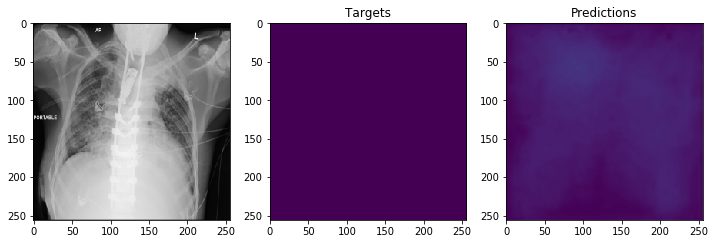

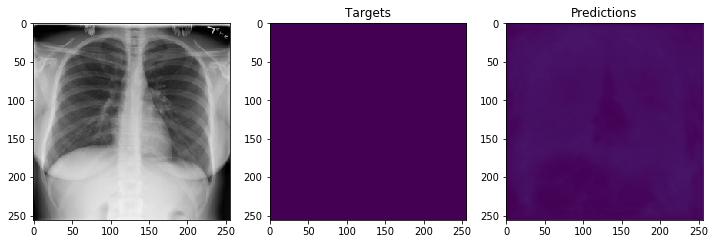

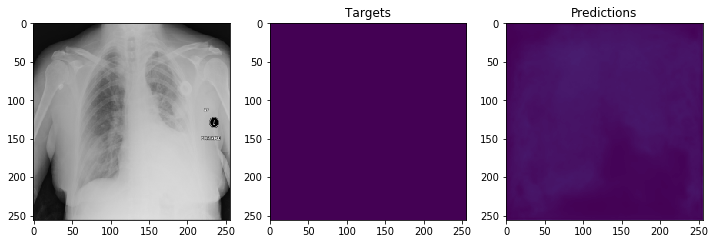

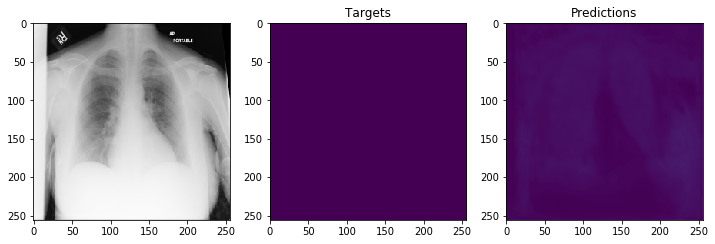

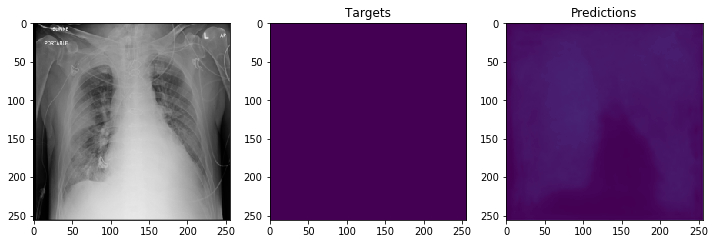

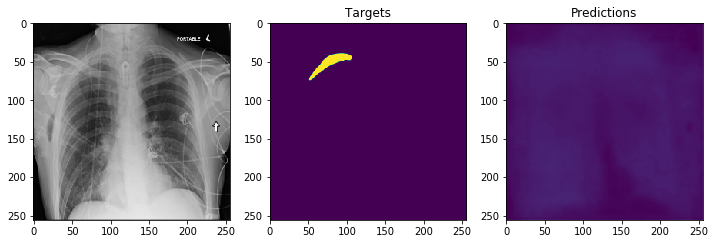

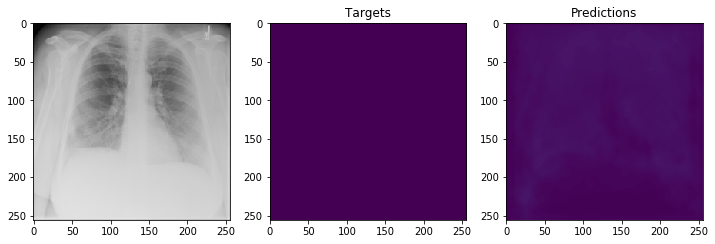

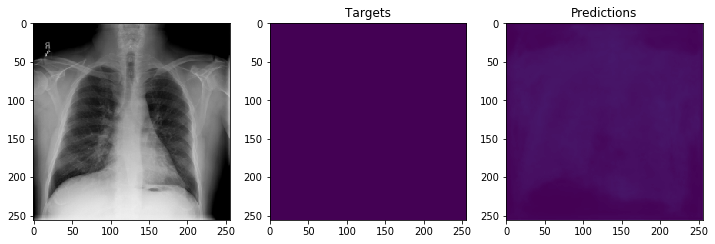

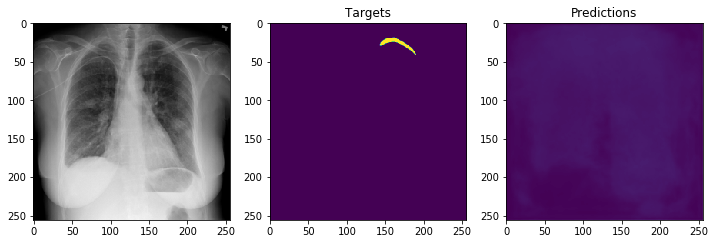

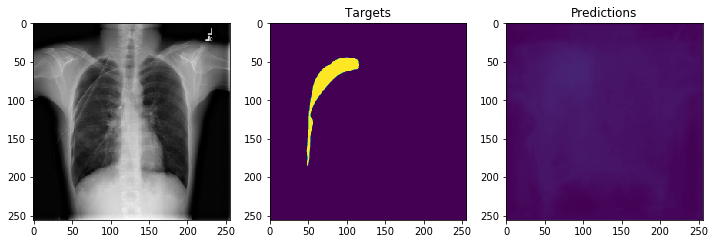

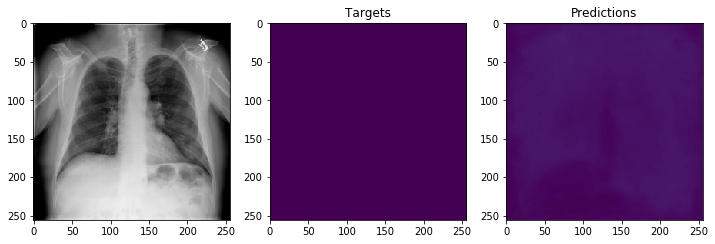

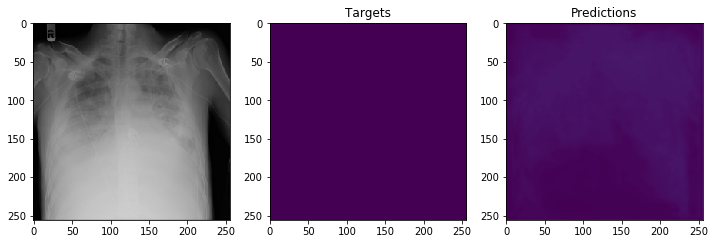

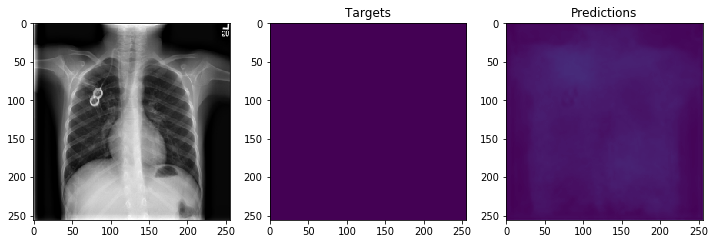

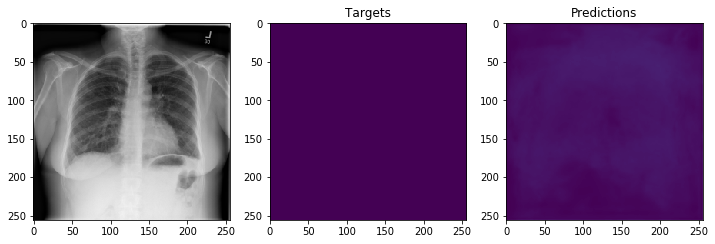

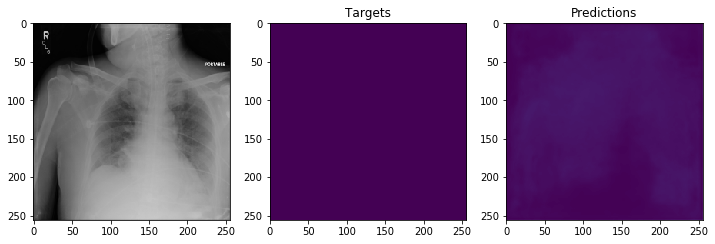

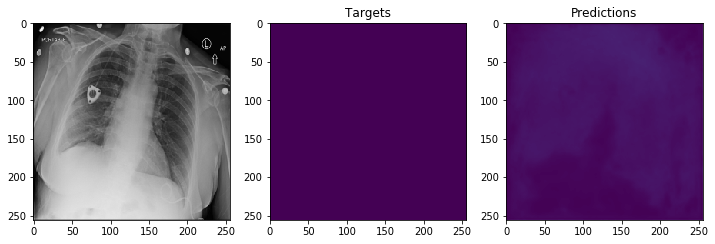

  1%|          | 2/168 [00:05<05:08,  1.86s/it]

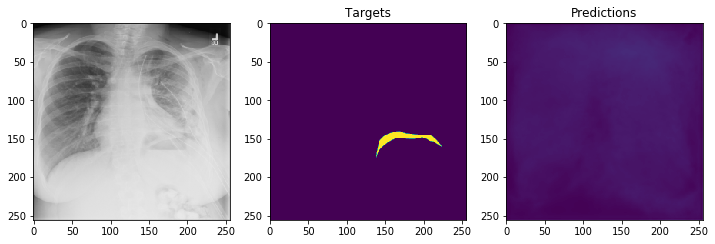

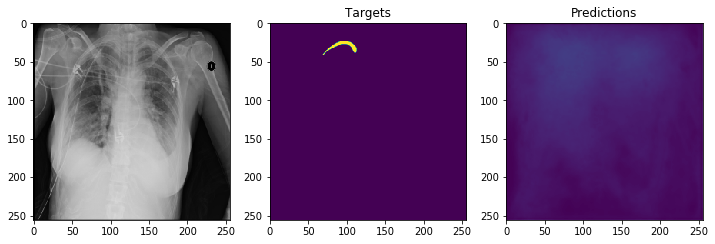

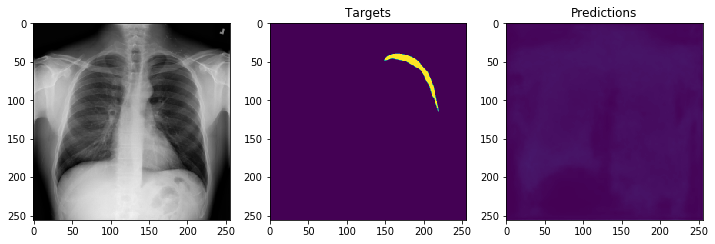

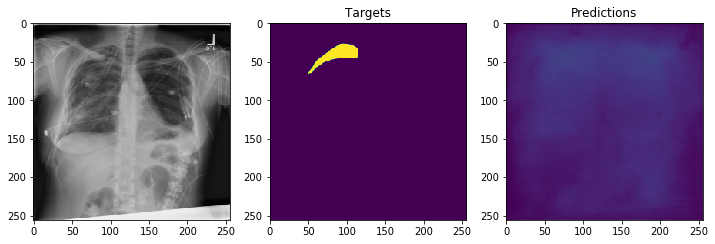

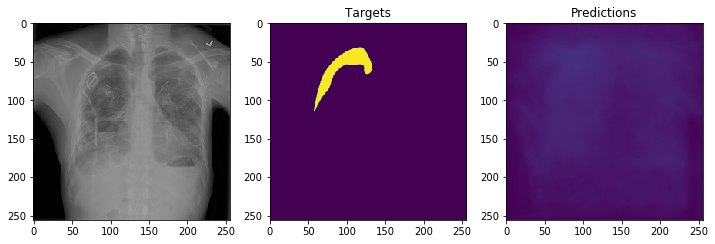

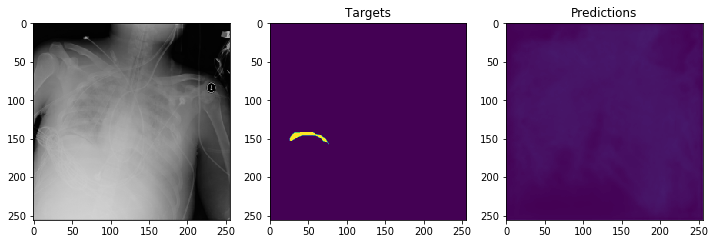

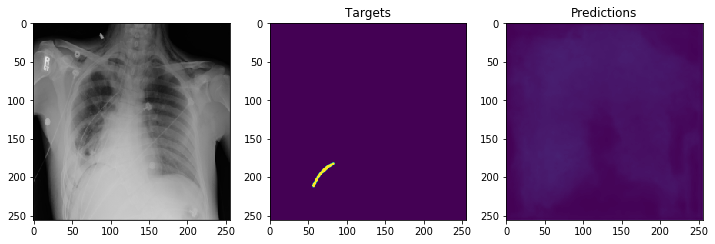

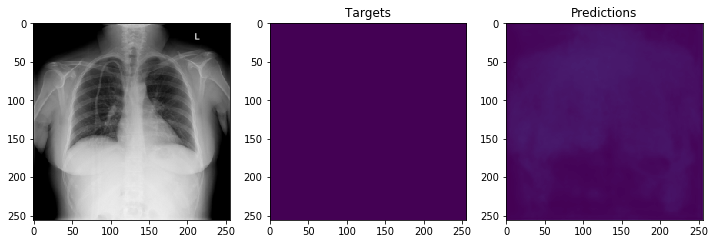

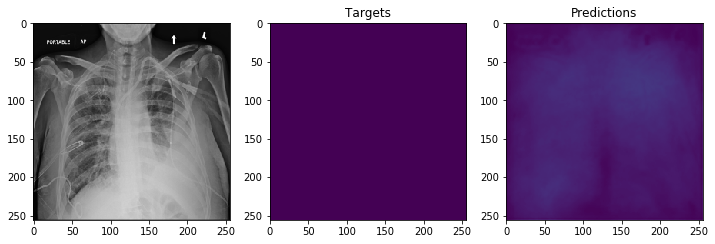

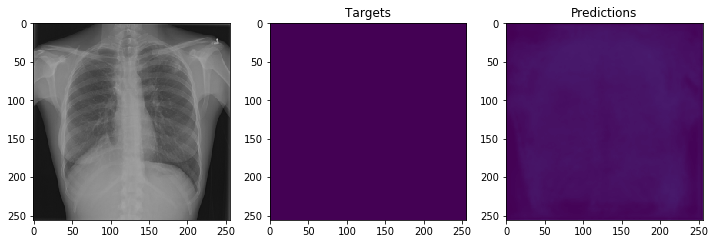

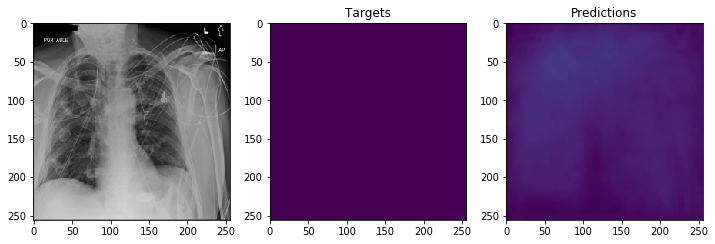

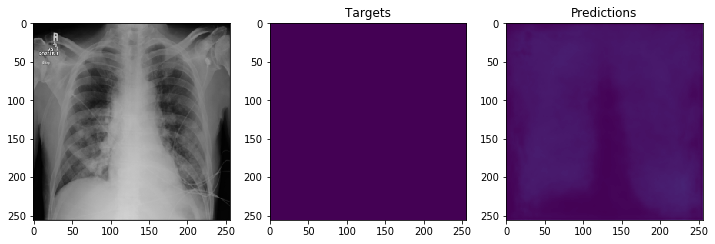

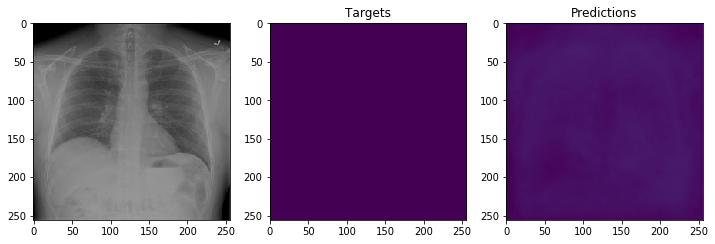

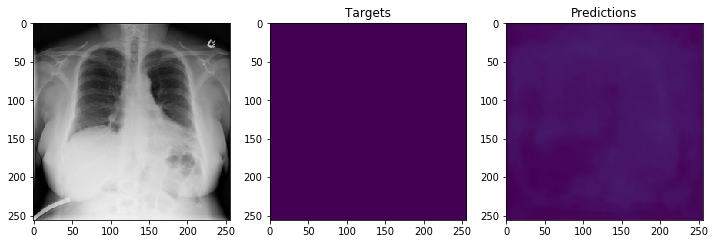

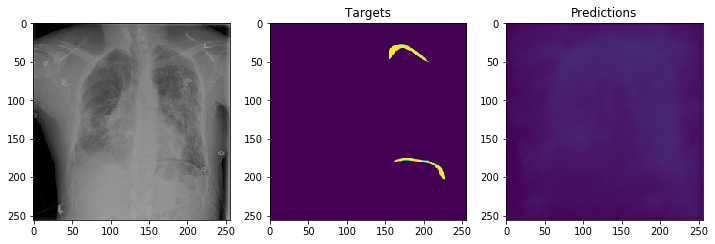

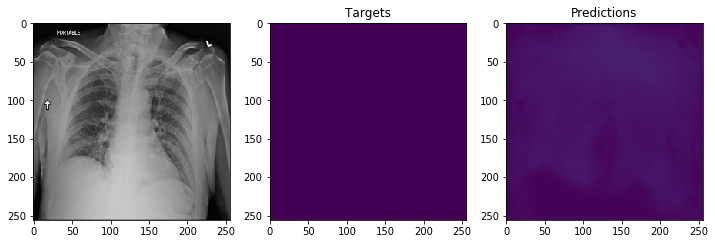

  2%|▏         | 3/168 [00:09<07:01,  2.55s/it]

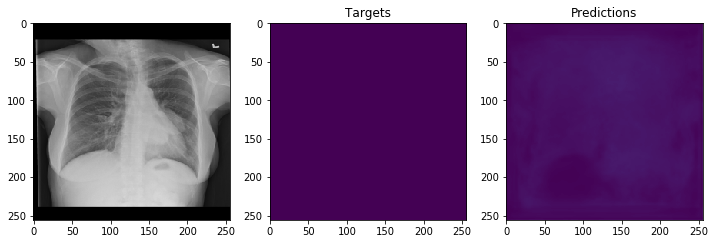

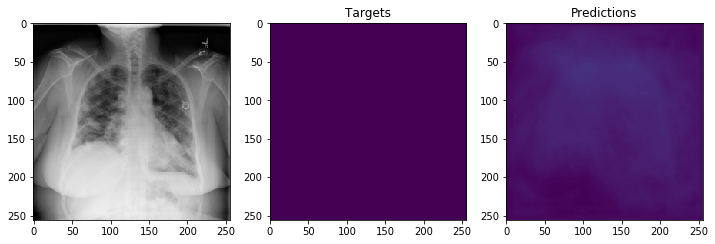

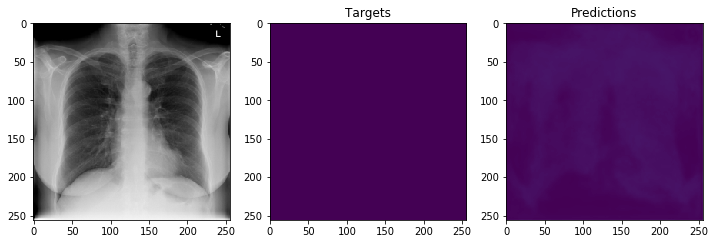

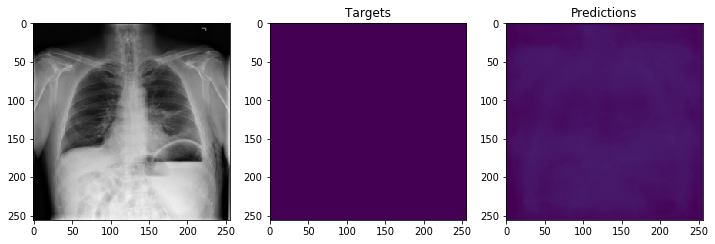

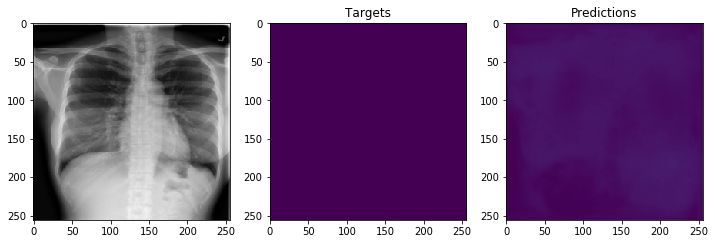

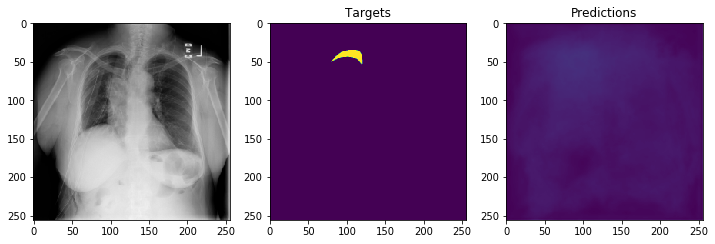

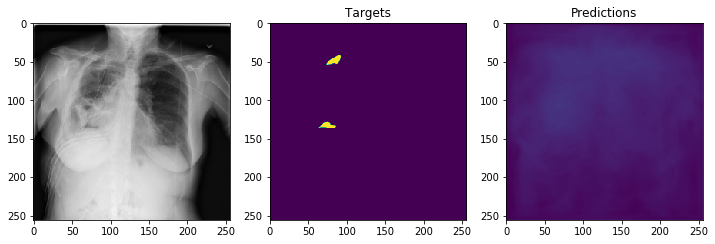

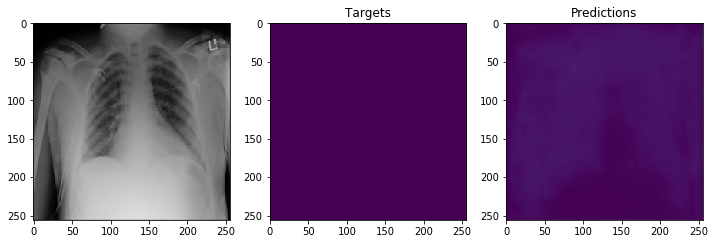

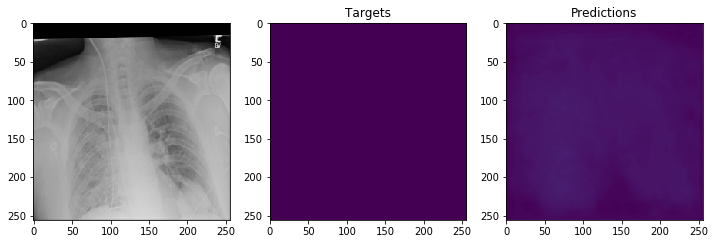

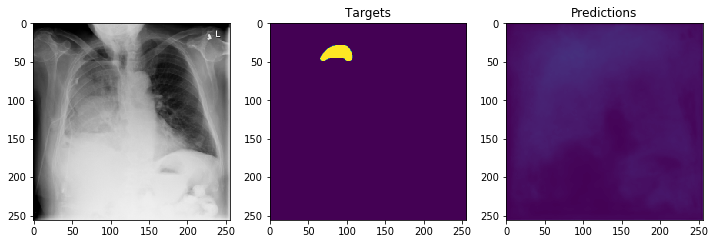

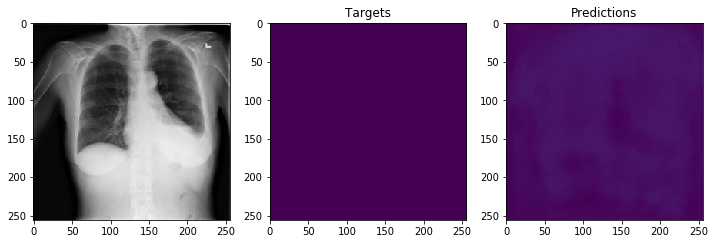

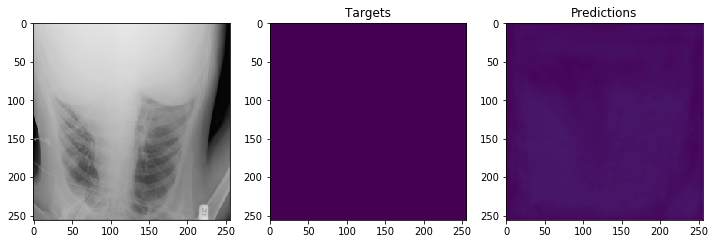

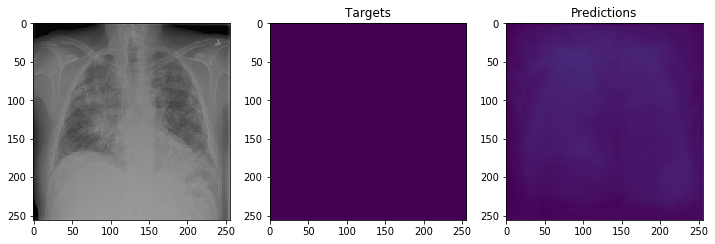

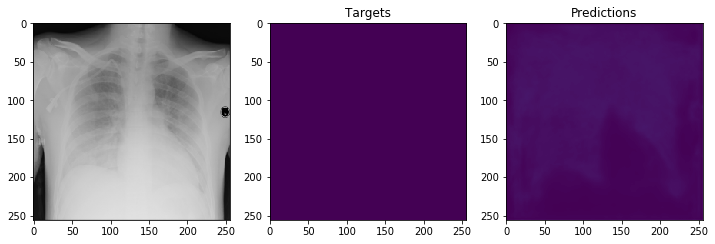

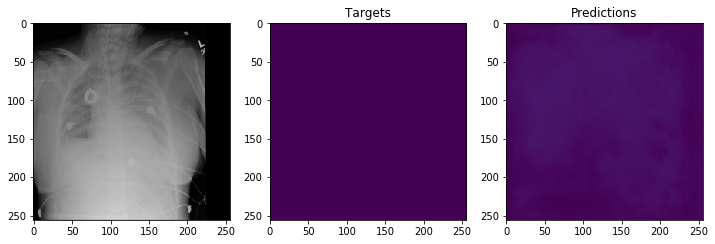

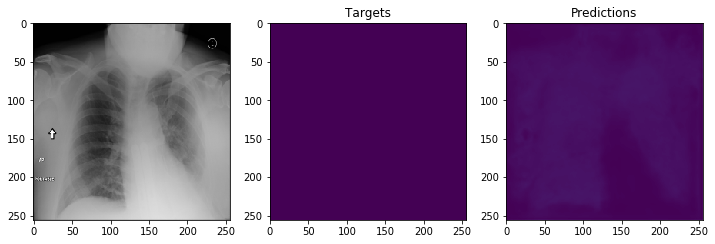

  2%|▏         | 4/168 [00:13<08:15,  3.02s/it]

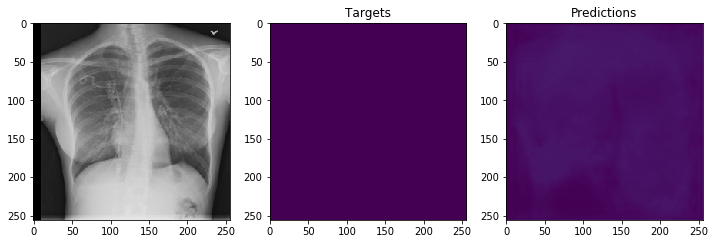

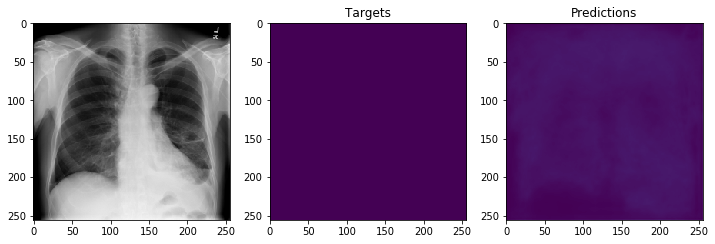

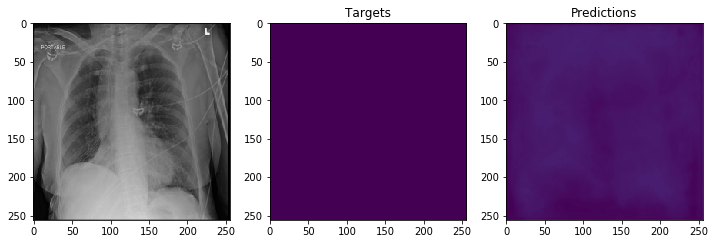

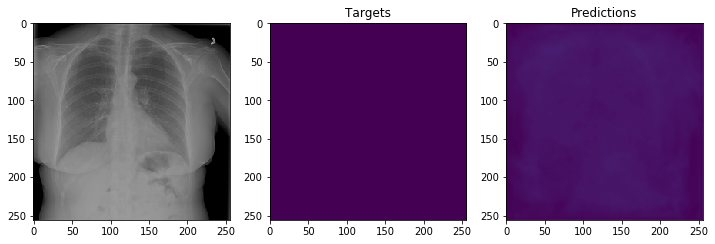

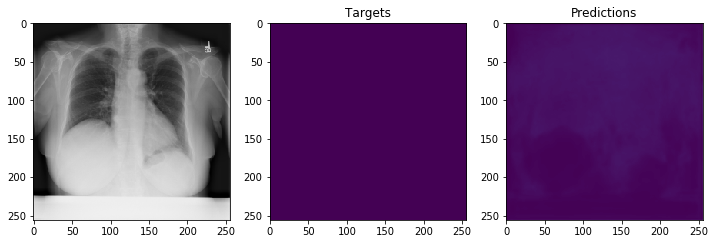

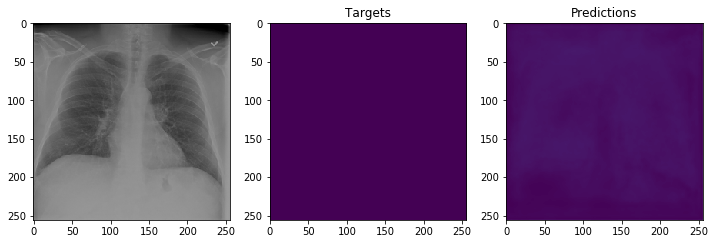

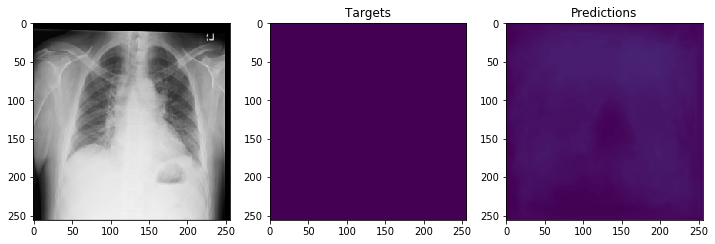

KeyboardInterrupt: 

In [22]:
# load saved model

tag = '20190723-152524_256'
# tag = '20190723-014424_256'
nfolds = 4

scores, best_thrs = [],[]

for fold in range(nfolds):
    print('\nfold {}:\n'.format(fold))
    
    train_loader, val_loader = get_dataloaders(
        data_root,
        batch_size,
        fold, nfolds=nfolds,
        width=SIZE, height=SIZE,
        train_augment=train_augment, val_augment=valid_augment,
        random_state=SEED
    )
    
    net = Net().cuda()
    net.load_state_dict(torch.load('unet_{}_fold{}.pth'.format(tag, fold)))
    
    probs, truths = fake_tta(net, val_loader)

    # noise removal
    probs[probs.view(probs.shape[0], -1).sum(-1) < noise_th,...] = 0.0
    
    # search best threshold for this fold
    dices = []
    thrs = np.arange(0.01, 1, 0.01)

    probs = probs.cuda()
    truths = truths.cuda()
    
    with tqdm(total=len(thrs), file=sys.stdout) as pbar:
        for th in thrs:
            preds = (probs>th).long()
            dices.append(dice_overall(preds, truths).mean())
            
            pbar.update(1)
        
    dices = np.array(dices)    
    
    # save best
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])

    print(dices, scores, best_thrs)

    # clean up
    if fold != nfolds-1: 
        del probs, truths, preds

    gc.collect()
    torch.cuda.empty_cache()
    

In [ ]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())

print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

In [ ]:
# show dice-thr plot for the LAST fold

best_dice = dices.max()

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)

plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()

## submission

In [ ]:
'''
def test_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    image = do_resize(image, SIZE, SIZE)
    image = do_center_pad_to_factor(image, factor = FACTOR)
    return image,mask,index,cache
'''

test_dataset = SIIMDataset(
    data_root,
    0,
    width=width, height=height,
    phase='test',
    augment=null_augment
)

test_loader  = DataLoader(
    test_dataset,
    batch_size  = batch_size,
    drop_last   = False,
    num_workers = 8,
    pin_memory  = True,
    collate_fn  = null_collate
)


In [ ]:
for fold in range(nfolds):
    print('fold: {}'.format(fold))
    
    net = Net().cuda()
    net.load_state_dict(torch.load('unet_{}_{}.pth'.format(tag, fold)))
    
    probs, _ = tta(net, test_loader)
    
    if fold == 0:
        all_probs = probs
    else:
        all_probs += probs
        
    gc.collect()
    torch.cuda.empty_cache()
    
all_probs /= nfolds


In [ ]:
# noise removal

probs_clean = all_probs.clone()

probs_clean[probs_clean.view(probs_clean.shape[0], -1).sum(-1) < noise_th,...] = 0.0


In [ ]:
# majority vote - no we don't actually use vote

# best_thr = 0.2

print('best_thr: {}'.format(best_thr))

pt_vote = torch.where(probs_clean > best_thr, torch.ones_like(probs_clean), torch.zeros_like(probs_clean))
pt_vote = pt_vote.numpy()


In [ ]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)

    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rle_list = pool.map(mask_worker, pt_vote)


In [ ]:
now = datetime.now()

ids = [os.path.splitext(filename)[0] for filename in test_dataset.filenames]

sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rle_list})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'

sub_df.to_csv('unet_sub_{}_{:.6f}.csv'.format(now.strftime('%Y%m%d-%H%M%S'), np.array(scores).mean()), index=False)
sub_df.head()
